<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Pull-out-some-test-data-that-the-model-will-never-train-on-but-only-be-evaluated-on" data-toc-modified-id="Pull-out-some-test-data-that-the-model-will-never-train-on-but-only-be-evaluated-on-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Pull out some test data that the model will never train on but only be evaluated on</a></span></li></ul></li><li><span><a href="#Algorithms-&amp;-Search" data-toc-modified-id="Algorithms-&amp;-Search-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Algorithms &amp; Search</a></span><ul class="toc-item"><li><span><a href="#Set-up-paramater-grid-for-RandomSearch-to-get-hyperparameters" data-toc-modified-id="Set-up-paramater-grid-for-RandomSearch-to-get-hyperparameters-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Set up paramater grid for RandomSearch to get hyperparameters</a></span><ul class="toc-item"><li><span><a href="#Random-Forest-parameters" data-toc-modified-id="Random-Forest-parameters-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Random Forest parameters</a></span></li><li><span><a href="#K-nearest-neighbors-classifier" data-toc-modified-id="K-nearest-neighbors-classifier-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>K nearest neighbors classifier</a></span></li></ul></li><li><span><a href="#Make-and-fit-pipes" data-toc-modified-id="Make-and-fit-pipes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Make and fit pipes</a></span></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#K-Nearest-Neighbor" data-toc-modified-id="K-Nearest-Neighbor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>K Nearest Neighbor</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
from   sklearn.metrics            import balanced_accuracy_score
from   sklearn.model_selection    import RandomizedSearchCV
from   sklearn.preprocessing      import StandardScaler
from   sklearn.ensemble           import RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from   sklearn.model_selection    import train_test_split
from   sklearn.metrics            import roc_auc_score
import scipy.stats
import seaborn as sns
from   sklearn.metrics            import classification_report, confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
from   sklearn.model_selection    import cross_val_score
from   sklearn.pipeline           import Pipeline
from   sklearn.feature_selection  import SelectKBest, chi2
from   sklearn.neighbors          import KNeighborsClassifier



## Load Data

In [2]:
cancer_data = pd.read_csv('https://mllabfinal.s3-us-west-1.amazonaws.com/cancer_data.csv', index_col=0)

### Pull out some test data that the model will never train on but only be evaluated on

In [3]:
X = cancer_data[cancer_data.columns[:-1]]
y = cancer_data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Algorithms & Search

__For my data the primary form of feature engineering is using feature importance to reduce dimensionality. Since I'm using Random Forest, scaling is not necessary. I'll have to find a good model to extract the features from first__

### Set up paramater grid for RandomSearch to get hyperparameters

#### Random Forest parameters

In [4]:
# Number of features to consider at every split
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num =10)]
# Maximum number of levels in tree
max_features = ['auto', 'sqrt','log2']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required to split a node
max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_split = [2, 5, 10]
# Method of selecting samples for training each tree
min_samples_leaf = [1, 2, 4]
# Create the random grid
bootstrap = [True, False]

random_grid_rf = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}

#### K nearest neighbors classifier

In [5]:
# Number of neighbors that will weigh in on the vote
n_neighbors = np.arange(1, 20, 2)
# Whether or not distance is accounted for
weights = ['uniform', 'distance']
# Metric for weights
metric = ['euclidean', 'manhattan']
# Algorithm used to compute the nearest neighbors
alg = ['auto', 'ball_tree', 'kd_tree', 'brute']

random_grid_knn = {'n_neighbors': n_neighbors,
               'weights': weights,
               'metric': metric,
               'algorithm': alg}

### Make and fit pipes

In [15]:
pipe1 = Pipeline([('skb', SelectKBest(chi2, k = 50)),
                 ('model', RandomizedSearchCV(estimator=RandomForestClassifier(),\
                            param_distributions=random_grid_rf,\
                            n_iter=13, cv=5, verbose=0,\
                            n_jobs=-2,\
                            scoring='roc_auc_ovr_weighted'))])

pipe1.fit(X_train, y_train)
best_rf_model = pipe1['model'].best_estimator_
y_pred_rf = best_rf_model.predict(pipe1['skb'].transform(X_test))
acc = balanced_accuracy_score(y_test, y_pred_rf)
print(f"Balanced Accuracy Score: {acc}")

Balanced Accuracy Score: 1.0


In [7]:
pipe2 = Pipeline([('skb', SelectKBest(chi2, k = 300)),
                 ('model', RandomizedSearchCV(estimator=KNeighborsClassifier(),\
                            param_distributions=random_grid_knn,\
                            n_iter=13, cv=5, verbose=0,\
                            n_jobs=-2,\
                            scoring='roc_auc_ovr_weighted'))])

pipe2.fit(X_train, y_train)
best_knn_model = pipe2['model'].best_estimator_
y_pred_knn = best_knn_model.predict(pipe2['skb'].transform(X_test))
acc = balanced_accuracy_score(y_test, y_pred_knn)
print(f"Balanced Accuracy Score: {acc}")

Balanced Accuracy Score: 1.0


## Evaluation

__Because Both models perform perform perfectly evaluation metrics aren't very informative so I will focus on exploring the features that led to prediction__

### Random Forest

In [8]:
importances = best_rf_model.feature_importances_
feature_importances = [(feature, round(importance, 6))\
                       for feature,importance in \
                       zip(cancer_data.columns, importances)]

feature_importances = sorted(feature_importances,\
                             key = lambda x: x[1],\
                             reverse = True)
feature_imp_df = pd.DataFrame(feature_importances)

No handles with labels found to put in legend.


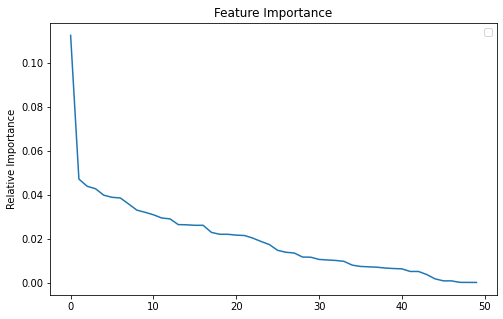

In [9]:
f, ax = plt.subplots(figsize=(8,5))
plt.plot(np.arange(len(feature_imp_df)), feature_imp_df[1])
plt.title('Feature Importance')
plt.ylabel('Relative Importance')
plt.legend()
plt.show()

In [10]:
accuracies = []
num_included = []
for num_cols in range(1, 50, 3):
    cols = feature_imp_df[0][:num_cols]

    rf_fit = RandomizedSearchCV(estimator=RandomForestClassifier(),\
                            param_distributions=random_grid_rf,\
                            n_iter=13, cv=5, verbose=3,\
                            n_jobs=-2,\
                            scoring='roc_auc_ovr_weighted')

    rf_fit.fit(X_train[cols], y_train)
    best_model = rf_fit.best_estimator_
    y_pred = best_model.predict(X_test[cols])
    acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Accuracy with {num_cols} features included in the dataset: {acc}")
    accuracies.append(acc)
    num_included.append(num_cols)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Accuracy with 1 features included in the dataset: 0.355669204934659
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Accuracy with 4 features included in the dataset: 0.5598087320852592
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Accuracy with 7 features included in the dataset: 0.5776447976590298
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Accuracy with 10 features included in the dataset: 0.6571247298240946
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Accuracy with 13 features included in the dataset: 0.6909762245203339
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Accuracy with 16 features included in the dataset: 0.713447677318525
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Accuracy with 19 features included in the dataset: 0.7683668406876599
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Accuracy with 22 features i

No handles with labels found to put in legend.


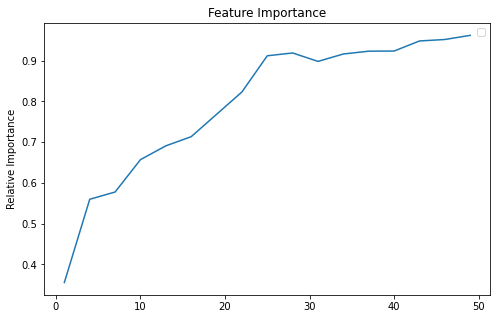

In [11]:
f, ax = plt.subplots(figsize=(8,5))
plt.plot(num_included, accuracies)
plt.title('Feature Importance')
plt.ylabel('Relative Importance')
plt.legend()
plt.show()

__This plot allows us to see that it only takes about 38 genes to accurately predict the type of cancer a patient has at 90% confidence, within the confines of the population that this data was collected from.__

### K Nearest Neighbor

In [12]:
knn_params = best_knn_model.get_params()
print(knn_params)

{'algorithm': 'ball_tree', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 13, 'p': 2, 'weights': 'distance'}


C:\Users\Teddy\.julia\conda\3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


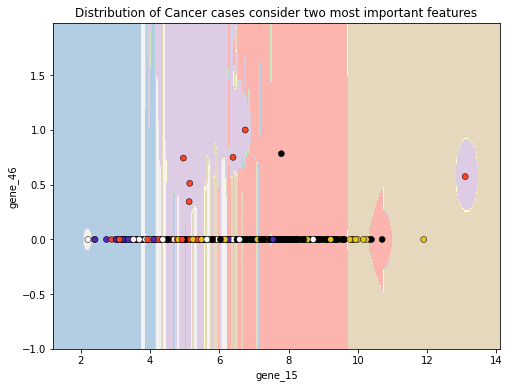

C:\Users\Teddy\.julia\conda\3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


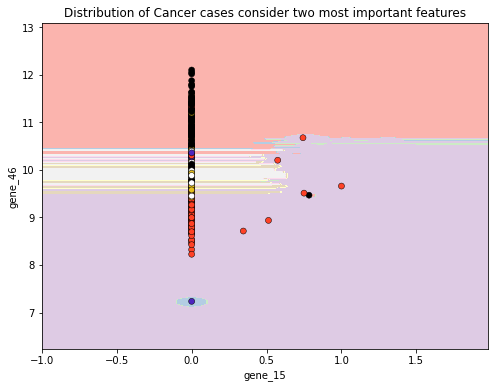

C:\Users\Teddy\.julia\conda\3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


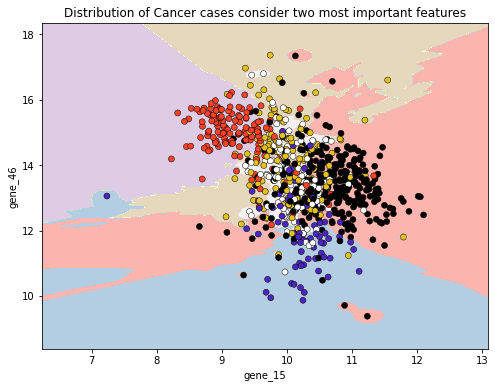

C:\Users\Teddy\.julia\conda\3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


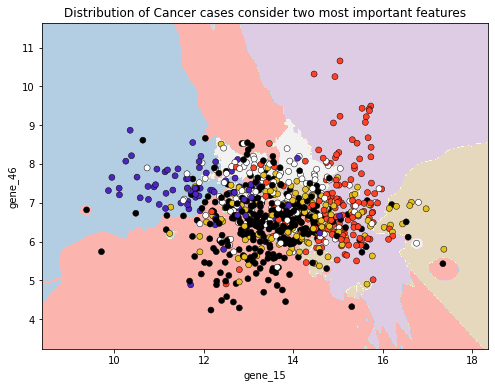

C:\Users\Teddy\.julia\conda\3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


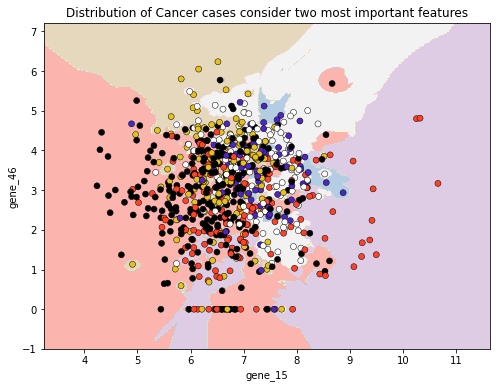

C:\Users\Teddy\.julia\conda\3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


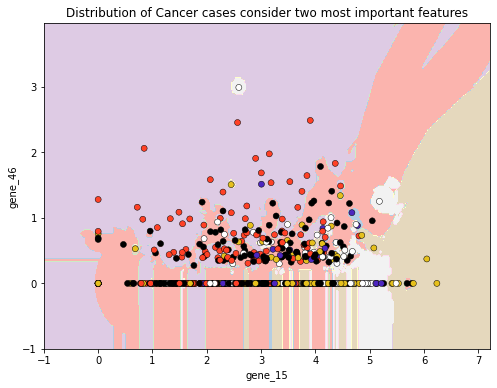

In [21]:
for i in range(6):
    X = cancer_data[cancer_data.columns[:-1]]
    y = cancer_data['Class']
    X_top_two = X[feature_imp_df[0][i:i+2]]
    X = X_top_two.values

    to_num = {'BRCA': 1, 'COAD': 2, 'KIRC': 3, 'LUAD': 4, 'PRAD': 5}
    y = y.replace(to_num).values
    h = .02  # step size in the mesh

    cmap_light = 'Pastel1'
    cmap_bold = 'CMRmap'

    clf = KNeighborsClassifier(**knn_params)
    clf.fit(X_top_two, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    X_min, X_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(X_min, X_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(X[:, 0], X[:, 1], c=y,
                    cmap=cmap_bold, alpha=1.0, edgecolor="black")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Distribution of Cancer cases consider two most important features")
    plt.xlabel(feature_imp_df[0][1])
    plt.ylabel(feature_imp_df[0][2])

    plt.show()

## Results

__In this analysis we have seen that the data collected on the genes is very good at predicting what type of cancer a patient has. It is possible to very accurately predict the cancer with only 50 genes when using a random forest classifier or with 300 features in KNN. I believe these models worked so well because cancer is a hereditary disease and is stongly linked with certain genes. Further, in the above figure we see that certain cancers are very clustered when looking at just two genes. This analysis can be extened to further pursue an understand of how the cancer presents in specific genes and what the minimum diagnostics are needed to accurately predict the cancer. This has the possibility to help guide research as well as be implemented in practice to reduce testing costs and thus the cost to both the individual and medical community.__

__The best model I obtained is a Random Forest Classifier with hyperparameters listed below__

In [22]:
best_rf_model.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 80,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 673,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}